*Notebook adapted from this [scikit-learn example](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)*

This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fai-courses%2Fautonomous_systems_ml/HEAD?filepath=notebooks%2F5_principal_component_analysis)

# Faces recognition example using eigenfaces and SVMs

This notebook shows that a dimension reduction method (e.g. PCA) can effectively improve the performance of the SVM classifier.

The dataset used in this example is a preprocessed excerpt of the
["Labeled Faces in the Wild"](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz)  (233MB), aka _LFW_.
  


Expected results for the top 5 most represented people in the dataset:


|                  | precision  |  recall  |  f1-score  | support|
|------------------|------------|----------|------------|--------|                 
|     Ariel Sharon |      0.67  |    0.92  |    0.77    |    13  |
|     Colin Powell |      0.75  |    0.78  |    0.76    |    60  |
|  Donald Rumsfeld |      0.78  |    0.67  |    0.72    |    27  |
|    George W Bush |      0.86  |    0.86  |    0.86    |   146  |
|Gerhard Schroeder |      0.76  |    0.76  |    0.76    |    25  |
|      Hugo Chavez |      0.67  |    0.67  |    0.67    |    15  |
|       Tony Blair |      0.81  |    0.69  |    0.75    |    36  |
|                  |            |          |            |        |
|      avg / total |      0.80  |   0.80   |   0.80     |  322   |

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

## Download the data, if not already on disk and load it as numpy arrays

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("class names: {}".format(target_names))


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


## Split into a training set and a test set

In [3]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction

In [4]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.280s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


# Train a SVM classification model

In [5]:
print("Fitting the classifier to the training set")
t0 = time()

# RBF kernel with cross validated parameters
param_grid = {'C': [.1, 1, 10, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 35.002s
Best estimator found by grid search:
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## Quantitative evaluation of the model quality on the test set

In [6]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.073s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.69      0.92      0.79        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.94      0.92      0.93       146
Gerhard Schroeder       0.91      0.84      0.87        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.94      0.81      0.87        36

         accuracy                           0.85       322
        macro avg       0.84      0.78      0.80       322
     weighted avg       0.87      0.85      0.86       322

[[  9   4   0   0   0   0   0]
 [  2  55   1   1   0   1   0]
 [  2   4  17   4   0   0   0]
 [  1  10   0 134   0   0   1]
 [  0   2   0   1  21   0   1]
 [  0   4   0   0   1  10   0]
 [  0   1   2   3   1   0  29]]


## Qualitative evaluation of the predictions using matplotlib

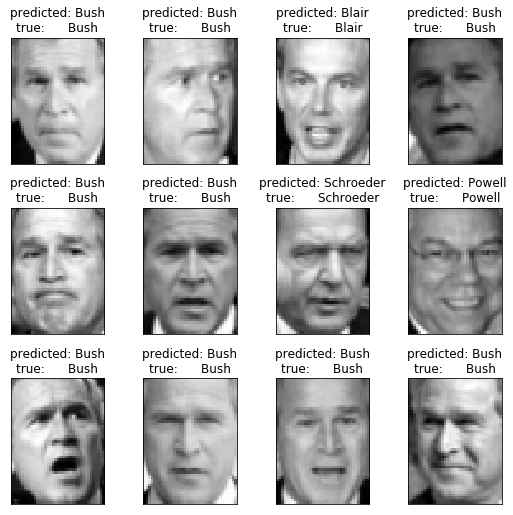

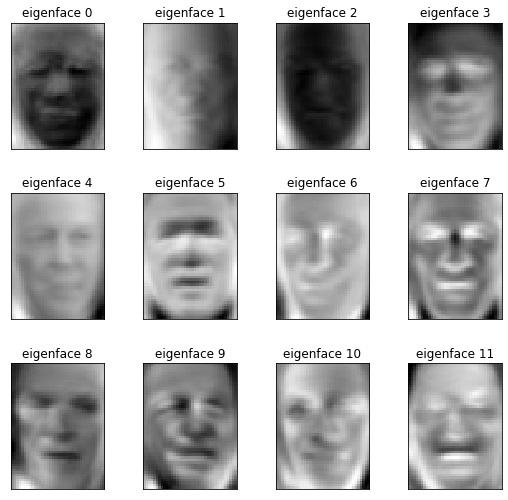

In [7]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### Exercise
- What is the interest to perform dimension reduction (PCA) before applying the classifier?
- Plot the mcr errors curves as a function of the number of retained pca features. What happen if we decrease/increase this number?